# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [26]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy import stats
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

616

In [ ]:
#print(cities)

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "standard"
query_url = f"{url}appid={weather_api_key}&units={units}&q="

In [4]:
# Loop through the list of cities and perform a request for data on each
responses = []

for city in cities:
    response = requests.get(query_url + city).json()
    responses.append(response)

In [ ]:
#responses

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [5]:
cities = [response.get('name') for response in responses]
lats = [response.get('coord', {}).get('lat') for response in responses]
longs = [response.get('coord', {}).get('lon') for response in responses]
max_temps = [response.get('main', {}).get('temp_max') for response in responses]
humidities = [response.get('main', {}).get('humidity') for response in responses]
cloudiness = [response.get('clouds', {}).get('all') for response in responses]
wind_speeds = [response.get('wind', {}).get('speed') for response in responses]
countries = [response.get('sys', {}).get('country') for response in responses]
dates = [response.get('dt') for response in responses]

In [6]:
weather_dictionary = {
    "City": cities,
    "Latitude": lats,
    "Longitude": longs,
    "Max Temp": max_temps,
    "Humidity": humidities,
    "Cloudiness": cloudiness,
    "Wind Speed": wind_speeds,
    "Country": countries,
    "Date": dates}

weather_data = pd.DataFrame(weather_dictionary)
weather_data

,City,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Karlskoga,59.3267,14.5239,268.52,96.0,100.0,4.58,SE,1.613531e+09
1,Bosaso,11.2842,49.1816,295.08,74.0,15.0,2.69,SO,1.613531e+09
2,Aksu,41.1231,80.2644,276.33,67.0,0.0,0.73,CN,1.613531e+09
3,Izhma,65.0083,53.9113,237.25,83.0,99.0,1.52,RU,1.613531e+09
4,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...
611,Kavaratti,10.5669,72.6420,300.30,65.0,71.0,4.87,IN,1.613531e+09
612,Fairfield,41.2668,-73.3162,277.15,64.0,90.0,3.09,US,1.613531e+09
613,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
614,Meridian,43.6121,-116.3915,273.57,93.0,100.0,1.88,US,1.613531e+09


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [46]:
#no cities with humidity >100
clean_city_data = weather_data.loc[(weather_data["Humidity"]) <= 100]
clean_city_data

,City,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Karlskoga,59.3267,14.5239,268.52,96.0,100.0,4.58,SE,1.613531e+09
1,Bosaso,11.2842,49.1816,295.08,74.0,15.0,2.69,SO,1.613531e+09
2,Aksu,41.1231,80.2644,276.33,67.0,0.0,0.73,CN,1.613531e+09
3,Izhma,65.0083,53.9113,237.25,83.0,99.0,1.52,RU,1.613531e+09
5,Banjar,-8.1900,114.9675,303.15,74.0,20.0,5.66,ID,1.613531e+09
...,...,...,...,...,...,...,...,...,...
610,Jinxiang,27.4327,120.6062,285.12,74.0,47.0,4.88,CN,1.613531e+09
611,Kavaratti,10.5669,72.6420,300.30,65.0,71.0,4.87,IN,1.613531e+09
612,Fairfield,41.2668,-73.3162,277.15,64.0,90.0,3.09,US,1.613531e+09
614,Meridian,43.6121,-116.3915,273.57,93.0,100.0,1.88,US,1.613531e+09


In [49]:
# Extract relevant fields from the data frame
clean_city_data = clean_city_data[['City', 'Latitude', 'Longitude', 'Max Temp', 'Humidity', 'Cloudiness', 'Wind Speed', 'Country']]

# Export the City_Data into a csv
clean_city_data.to_csv("weather_data.csv")

In [11]:
clean_city_data

,City,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Karlskoga,59.3267,14.5239,268.52,96.0,100.0,4.58,SE,1.613531e+09
1,Bosaso,11.2842,49.1816,295.08,74.0,15.0,2.69,SO,1.613531e+09
2,Aksu,41.1231,80.2644,276.33,67.0,0.0,0.73,CN,1.613531e+09
3,Izhma,65.0083,53.9113,237.25,83.0,99.0,1.52,RU,1.613531e+09
5,Banjar,-8.1900,114.9675,303.15,74.0,20.0,5.66,ID,1.613531e+09
...,...,...,...,...,...,...,...,...,...
610,Jinxiang,27.4327,120.6062,285.12,74.0,47.0,4.88,CN,1.613531e+09
611,Kavaratti,10.5669,72.6420,300.30,65.0,71.0,4.87,IN,1.613531e+09
612,Fairfield,41.2668,-73.3162,277.15,64.0,90.0,3.09,US,1.613531e+09
614,Meridian,43.6121,-116.3915,273.57,93.0,100.0,1.88,US,1.613531e+09


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

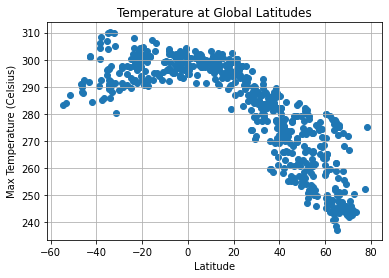

In [21]:
# LATITUDE VS TEMP
plt.scatter(weather_data["Latitude"], weather_data["Max Temp"], marker="o")

# Incorporate the other graph properties
plt.title("Temperature at Global Latitudes")
plt.ylabel("Max Temperature (Celsius)")
plt.xlabel("Latitude")
plt.grid(True)

# Save the figure
#plt.savefig("TemperatureInWorldCities.png")

# Show plot
plt.show()

#explanation: lower latitudes have higher max temps and higher latitudes have lower max temps, slight curve as well

## Latitude vs. Humidity Plot

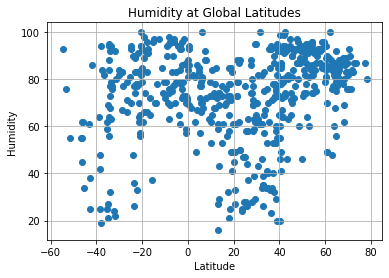

In [22]:
# LATITUDE VS HUMIDITY
plt.scatter(weather_data["Latitude"], weather_data["Humidity"], marker="o")

# Incorporate the other graph properties
plt.title("Humidity at Global Latitudes")
plt.ylabel("Humidity")
plt.xlabel("Latitude")
plt.grid(True)

# Save the figure
#plt.savefig("TemperatureInWorldCities.png")

# Show plot
plt.show()

#explanation: latitudes around 20-40 have lower humidity

## Latitude vs. Cloudiness Plot

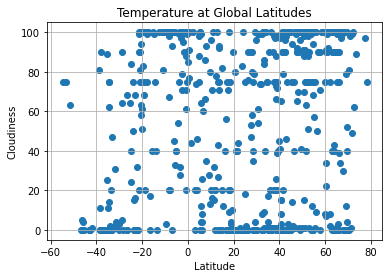

In [23]:
# LATITUDE VS CLOUDIDNESS
plt.scatter(weather_data["Latitude"], weather_data["Cloudiness"], marker="o")

# Incorporate the other graph properties
plt.title("Cloudiness at Global Latitudes")
plt.ylabel("Cloudiness")
plt.xlabel("Latitude")
plt.grid(True)

# Save the figure
#plt.savefig("TemperatureInWorldCities.png")

# Show plot
plt.show()

#explanation: weak correlation, cant draw much conclusion likely because clouds are often observed everywhere regularly

## Latitude vs. Wind Speed Plot

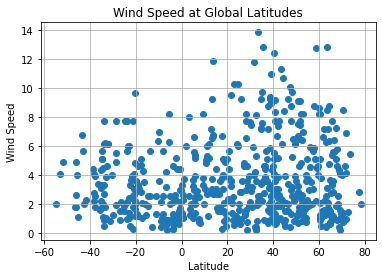

In [24]:
# LATITUDE VS WIND SPEED
plt.scatter(weather_data["Latitude"], weather_data["Wind Speed"], marker="o")

# Incorporate the other graph properties
plt.title("Wind Speed at Global Latitudes")
plt.ylabel("Wind Speed")
plt.xlabel("Latitude")
plt.grid(True)

# Save the figure
#plt.savefig("TemperatureInWorldCities.png")

# Show plot
plt.show()

#explanation: higher latitude appears to have slightly higher wind speeds

## Linear Regression

In [14]:
# OPTIONAL: Create a function to create Linear Regression plots

In [15]:
# Create Northern and Southern Hemisphere DataFrames

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

In [37]:
northern = weather_data.loc[(weather_data["Latitude"]) > 0]
northern

,City,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Karlskoga,59.3267,14.5239,268.52,96.0,100.0,4.58,SE,1.613531e+09
1,Bosaso,11.2842,49.1816,295.08,74.0,15.0,2.69,SO,1.613531e+09
2,Aksu,41.1231,80.2644,276.33,67.0,0.0,0.73,CN,1.613531e+09
3,Izhma,65.0083,53.9113,237.25,83.0,99.0,1.52,RU,1.613531e+09
6,Naze,28.3667,129.4833,286.15,58.0,75.0,7.72,JP,1.613531e+09
...,...,...,...,...,...,...,...,...,...
610,Jinxiang,27.4327,120.6062,285.12,74.0,47.0,4.88,CN,1.613531e+09
611,Kavaratti,10.5669,72.6420,300.30,65.0,71.0,4.87,IN,1.613531e+09
612,Fairfield,41.2668,-73.3162,277.15,64.0,90.0,3.09,US,1.613531e+09
614,Meridian,43.6121,-116.3915,273.57,93.0,100.0,1.88,US,1.613531e+09


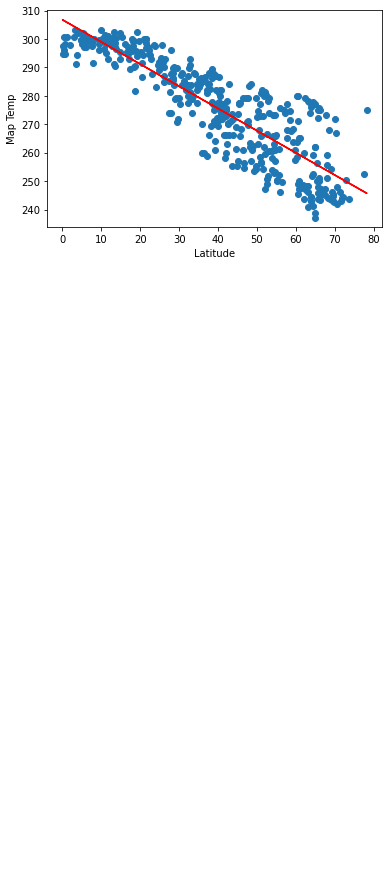

In [38]:
x_values = northern['Latitude']
y_values = northern['Max Temp']
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Map Temp')
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

In [34]:
southern = weather_data.loc[(weather_data["Latitude"]) < 0]
southern

,City,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
5,Banjar,-8.1900,114.9675,303.15,74.0,20.0,5.66,ID,1.613531e+09
7,Port Elizabeth,-33.9180,25.5701,292.15,68.0,0.0,6.17,ZA,1.613531e+09
9,Chimoio,-19.1164,33.4833,290.69,98.0,100.0,3.33,MZ,1.613531e+09
13,Tautira,-17.7333,-149.1500,303.15,66.0,75.0,5.14,PF,1.613531e+09
14,Kaeo,-35.1000,173.7833,296.48,69.0,11.0,3.13,NZ,1.613531e+09
...,...,...,...,...,...,...,...,...,...
576,Wewak,-3.5534,143.6268,299.63,84.0,100.0,1.33,PG,1.613531e+09
578,Mount Gambier,-37.8333,140.7667,308.54,19.0,0.0,1.84,AU,1.613531e+09
583,Yhú,-25.0500,-55.9167,293.18,70.0,24.0,1.86,PY,1.613531e+09
587,Piracanjuba,-17.3028,-49.0167,293.39,93.0,100.0,1.09,BR,1.613531e+09


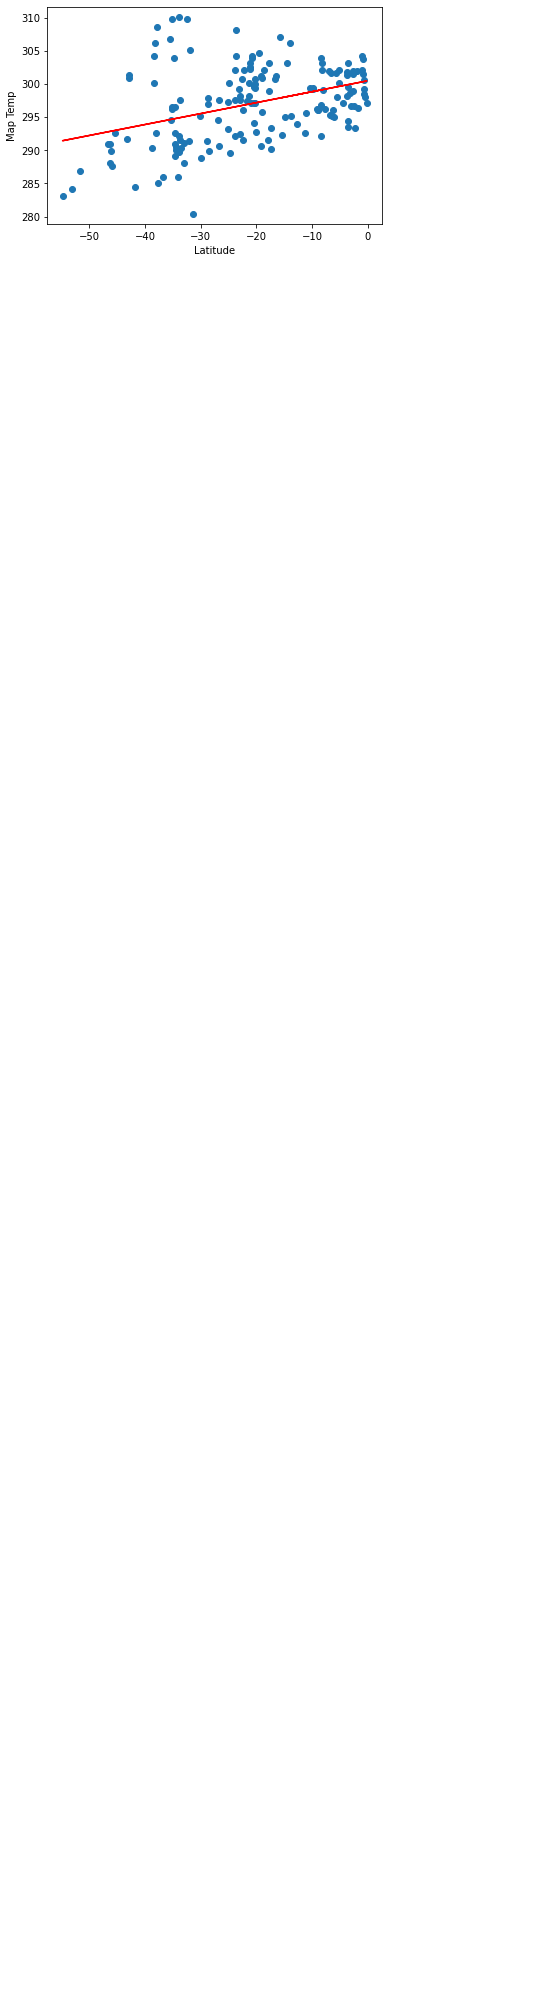

In [35]:
x_values = southern['Latitude']
y_values = southern['Max Temp']
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Map Temp')
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

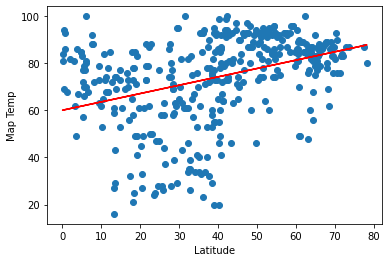

In [39]:
x_values = northern['Latitude']
y_values = northern['Humidity']
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Map Temp')
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

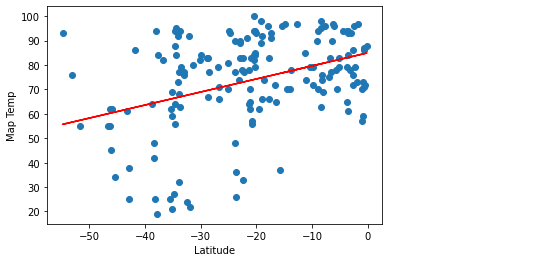

In [40]:
x_values = southern['Latitude']
y_values = southern['Humidity']
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Map Temp')
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

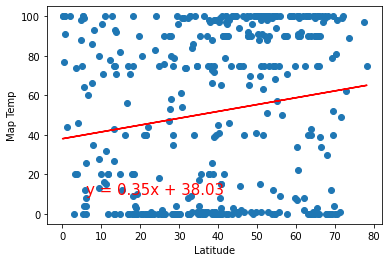

In [41]:
x_values = northern['Latitude']
y_values = northern['Cloudiness']
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Map Temp')
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

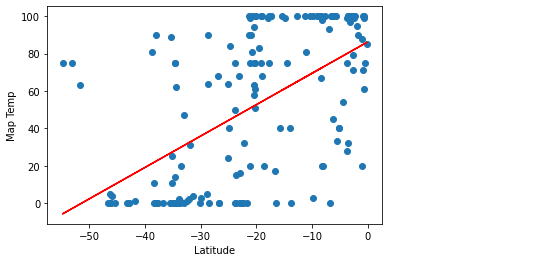

In [42]:
x_values = southern['Latitude']
y_values = southern['Cloudiness']
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Map Temp')
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

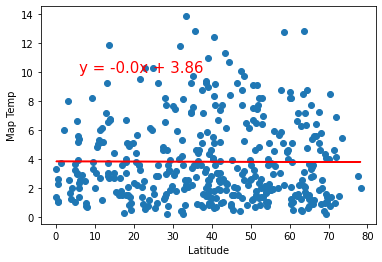

In [43]:
x_values = northern['Latitude']
y_values = northern['Wind Speed']
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Map Temp')
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

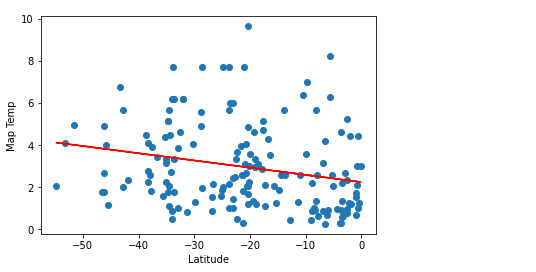

In [44]:
x_values = southern['Latitude']
y_values = southern['Wind Speed']
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Map Temp')
plt.show()